# RCSB Disulfide Bond Structural Geometry Analysis
Eric G. Suchanek, PhD, Flux-Frontiers, Cincinnati OH

## Summary
In this notebook I present an analysis of the geometry Disulfide Bonds extracted from the RCSB, using the ``proteusPy`` package. This analysis was performed against the entire database in order to clean it for more rigorous statistical analysis. The fundamental issues being addressed revolve around the quality of the Disulfide Bond structures themselves. Since the structures studied are the result of X-Ray crystallography the atomic coordinates are subject to positional uncertainties. These uncertainties can lead to unusual and/or non-physical structures that shouldn't be included in subsequent structural analyses.

## Utility Functions

In [16]:
import proteusPy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


def calculate_std_cutoff(df, column, num_std=2):
    """
    Calculate cutoff based on standard deviation.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param column: Column name for which to calculate the cutoff.
    :type column: str
    :param num_std: Number of standard deviations to use for the cutoff.
    :type num_std: int
    :return: Cutoff value.
    :rtype: float
    """
    mean = df[column].mean()
    std = df[column].std()
    cutoff = mean + num_std * std
    return cutoff


def calculate_percentile_cutoff(df, column, percentile=95):
    """
    Calculate cutoff based on percentile.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param column: Column name for which to calculate the cutoff.
    :type column: str
    :param percentile: Percentile to use for the cutoff.
    :type percentile: int
    :return: Cutoff value.
    :rtype: float
    """
    cutoff = np.percentile(df[column].dropna(), percentile)
    return cutoff


# Example usage
# distance_cutoff = calculate_percentile_cutoff(dev_df, 'Distance_Deviation', percentile=95)
# angle_cutoff = calculate_percentile_cutoff(dev_df, 'Angle_Deviation', percentile=95)


def create_deviation_dataframe(disulfide_list):
    """
    Create a DataFrame with columns PDB_ID, SS_Name, Angle_Deviation, Distance_Deviation, Ca Distance
    from a list of disulfides.

    :param disulfide_list: List of disulfide objects.
    :type proteusPy.DisulfideList: list
    :return: DataFrame containing the disulfide information.
    :rtype: pd.DataFrame
    """
    data = {
        "PDB_ID": [],
        "SS_Name": [],
        "Angle_Deviation": [],
        "Distance_Deviation": [],
        "Ca_Distance": [],
    }

    for ss in tqdm(disulfide_list, desc="Processing..."):
        pdb_id = ss.pdb_id
        ca_distance = ss.ca_distance
        angle_deviation = ss.bond_angle_ideality
        distance_deviation = ss.bond_length_ideality

        data["PDB_ID"].append(pdb_id)
        data["SS_Name"].append(ss.name)
        data["Angle_Deviation"].append(angle_deviation)
        data["Distance_Deviation"].append(distance_deviation)
        data["Ca_Distance"].append(ca_distance)

    df = pd.DataFrame(data)
    return df


def plot_histograms(df):
    """
    Plot histograms for Distance_Deviation, Angle_Deviation, and Ca_Distance.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    """
    plt.figure(figsize=(21, 6))

    # Bond Length Deviation Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df["Distance_Deviation"], kde=True, bins=30)
    plt.title("Bond Length Deviation Distribution")
    plt.xlabel("Bond Length Deviation")
    plt.ylabel("Frequency")

    # Angle Deviation Histogram
    plt.subplot(1, 3, 2)
    sns.histplot(df["Angle_Deviation"], kde=True, bins=30)
    plt.title("Angle Deviation Distribution")
    plt.xlabel("Angle Deviation")
    plt.ylabel("Frequency")

    # Ca_Distance Histogram
    plt.subplot(1, 3, 3)
    sns.histplot(df["Ca_Distance"], kde=True, bins=30)
    plt.title("Ca Distance Distribution")
    plt.xlabel("Ca Distance")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


def highlight_worst_structures(df, top_n=10):
    """
    Highlight the worst structures for distance and angle deviations and annotate their names.
    Also, add a subplot showing the worst structures aggregated by PDB_ID.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    :param top_n: Number of worst structures to highlight.
    :type top_n: int
    """
    # Identify the worst structures for Bond Length Deviation
    worst_distance = df.nlargest(top_n, "Distance_Deviation")

    # Identify the worst structures for angle deviation
    worst_angle = df.nlargest(top_n, "Angle_Deviation")

    # Identify the worst structures for Ca distance
    worst_ca = df.nlargest(top_n, "Ca_Distance")

    # Combine the worst structures
    worst_structures = pd.concat(
        [worst_distance, worst_angle, worst_ca]
    ).drop_duplicates()

    # Aggregate worst structures by PDB_ID
    worst_structures_agg = (
        worst_structures.groupby("PDB_ID").size().reset_index(name="Count")
    )

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Scatter plot for all structures
    sns.scatterplot(
        x="Distance_Deviation",
        y="Angle_Deviation",
        data=df,
        label="All Structures",
        ax=axes[0],
    )

    # Highlight the worst structures
    sns.scatterplot(
        x="Distance_Deviation",
        y="Angle_Deviation",
        data=worst_structures,
        color="red",
        label="Worst Structures",
        marker="X",
        s=100,
        ax=axes[0],
    )

    # Annotate the worst structures with their names
    for i, row in worst_structures.iterrows():
        axes[0].annotate(
            row["SS_Name"],
            (row["Distance_Deviation"], row["Angle_Deviation"]),
            textcoords="offset points",
            xytext=(5, 5),
            ha="left",
        )

    axes[0].set_title("Bond Length Deviation vs. Angle Deviation")
    axes[0].set_xlabel("Bond Length Deviation")
    axes[0].set_ylabel("Angle Deviation")
    axes[0].legend()

    # Bar plot for worst structures aggregated by PDB_ID
    sns.barplot(x="PDB_ID", y="Count", data=worst_structures_agg, ax=axes[1])
    axes[1].set_title("Worst Structures Aggregated by PDB_ID")
    axes[1].set_xlabel("PDB_ID")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()


def highlight_worst_structures2(df, top_n=10):
    """
    Highlight the worst structures for distance and angle deviations and annotate their names.
    Also, add subplots showing the worst structures aggregated by PDB_ID for distance and angle deviations.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    :param top_n: Number of worst structures to highlight.
    :type top_n: int
    """
    # Identify the worst structures for Bond Length Deviation
    worst_distance = df.nlargest(top_n, "Distance_Deviation")

    # Identify the worst structures for angle deviation
    worst_angle = df.nlargest(top_n, "Angle_Deviation")

    # Combine the worst structures
    worst_structures = pd.concat([worst_distance, worst_angle]).drop_duplicates()

    # Aggregate worst structures by PDB_ID for distance and angle deviations
    worst_distance_agg = (
        worst_distance.groupby("PDB_ID").size().reset_index(name="Count")
    )
    worst_angle_agg = worst_angle.groupby("PDB_ID").size().reset_index(name="Count")

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Histogram for Bond Length Deviation
    sns.histplot(df["Distance_Deviation"], kde=True, bins=30, ax=axes[0])
    axes[0].set_title("Bond Length Deviation Distribution")
    axes[0].set_xlabel("Bond Length Deviation")
    axes[0].set_ylabel("Frequency")

    # Histogram for angle deviation
    sns.histplot(df["Angle_Deviation"], kde=True, bins=30, ax=axes[1])
    axes[1].set_title("Angle Deviation Distribution")
    axes[1].set_xlabel("Angle Deviation")
    axes[1].set_ylabel("Frequency")

    # Bar plots for worst structures aggregated by PDB_ID
    sns.barplot(
        x="PDB_ID",
        y="Count",
        data=worst_distance_agg,
        ax=axes[2],
        color="blue",
        label="Bond Length Deviation",
    )
    sns.barplot(
        x="PDB_ID",
        y="Count",
        data=worst_angle_agg,
        ax=axes[2],
        color="green",
        label="Angle Deviation",
        alpha=0.6,
    )
    axes[2].set_title("Worst Structures Aggregated by PDB_ID")
    axes[2].set_xlabel("PDB_ID")
    axes[2].set_ylabel("Count")
    axes[2].tick_params(axis="x", rotation=90)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


# Example usage
# Assuming you have a DataFrame named dev_df
# highlight_worst_structures(dev_df, top_n=10)


def calculate_std_cutoff(df, column, num_std=2):
    """
    Calculate cutoff based on standard deviation.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param column: Column name for which to calculate the cutoff.
    :type column: str
    :param num_std: Number of standard deviations to use for the cutoff.
    :type num_std: int
    :return: Cutoff value.
    :rtype: float
    """
    mean = df[column].mean()
    std = df[column].std()
    cutoff = mean + num_std * std
    return cutoff


def calculate_percentile_cutoff(df, column, percentile=95):
    """
    Calculate cutoff based on percentile.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param column: Column name for which to calculate the cutoff.
    :type column: str
    :param percentile: Percentile to use for the cutoff.
    :type percentile: int
    :return: Cutoff value.
    :rtype: float
    """
    cutoff = np.percentile(df[column].dropna(), percentile)
    return cutoff


def filter_by_cutoffs(df, distance_cutoff=1.0, angle_cutoff=1.0, ca_cutoff=8.0):
    """
    Filter the DataFrame based on distance, angle, and Ca distance cutoffs. Ca cutoff
    dominates the filter and will override the distance and angle cutoffs.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param distance_cutoff: Cutoff value for Bond Length Deviation.
    :type distance_cutoff: float
    :param angle_cutoff: Cutoff value for angle deviation.
    :type angle_cutoff: float
    :param ca_cutoff: Cutoff value for Ca distance.
    :type ca_cutoff: float
    :return: Filtered DataFrame.
    :rtype: pd.DataFrame
    """
    filtered_df = df[
        (df["Distance_Deviation"] <= distance_cutoff)
        & (df["Angle_Deviation"] <= angle_cutoff)
        | (df["Ca_Distance"] <= ca_cutoff)
    ]
    return filtered_df


def bad_filter_by_cutoffs(df, distance_cutoff=1.0, angle_cutoff=1.0, ca_cutoff=8.0):
    """
    Return the DataFrame objects that are GREATER than the cutoff based on distance,
    angle, and Ca distance cutoffs. Used to get the bad structures. Ca cutoff
    dominates the filter and will override the distance and angle cutoffs.

    :param df: DataFrame containing the deviations.
    :type df: pd.DataFrame
    :param distance_cutoff: Cutoff value for Bond Length Deviation.
    :type distance_cutoff: float
    :param angle_cutoff: Cutoff value for angle deviation.
    :type angle_cutoff: float
    :param ca_cutoff: Cutoff value for Ca distance.
    :type ca_cutoff: float
    :return: Filtered DataFrame.
    :rtype: pd.DataFrame
    """
    filtered_df = df[
        (df["Distance_Deviation"] > distance_cutoff)
        & (df["Angle_Deviation"] > angle_cutoff)
        | (df["Ca_Distance"] > ca_cutoff)
    ]
    return filtered_df

## Background
``proteusPy`` (https://doi.org/10.21105/joss.06169), is a Python package designed to analyze Disulfide Bonds in proteins of known structure. These disulfide bonds have been extracted from the RCSB Protein Databank (https://www.rcsb.org) using the package. proteusPy is freely available on GitHub at: https://github.com/suchanek/proteusPy.git, and the API documentation at: https://suchanek.github.io/proteusPy/proteusPy.html. I am actively developing the package and am working towards a high-quality database of structures. It's important to exclude structures that are not physically possible when building the database. As a result, I've written some routines to calculate cutoff values to exclude these 'bad' structures from the database itself.

In [17]:
from proteusPy import Load_PDB_SS

PDB_SS = Load_PDB_SS(subset=False, verbose=True)
PDB_SS.describe()

-> load_PDB_SS(): Reading /Users/egs/miniforge3/envs/ppydev/lib/python3.11/site-packages/proteusPy/data/PDB_SS_ALL_LOADER.pkl... 
-> load_PDB_SS(): Done reading /Users/egs/miniforge3/envs/ppydev/lib/python3.11/site-packages/proteusPy/data/PDB_SS_ALL_LOADER.pkl... 
    =========== RCSB Disulfide Database Summary ==============
       =========== Built: 2024-08-13 10:32:49 ==============
PDB IDs present:                    37075
Disulfides loaded:                  175649
Average structure resolution:       2.07 Å
Lowest Energy Disulfide:            2q7q_75D_140D
Highest Energy Disulfide:           6vxk_801B_806B
Cα distance cutoff:                 -1.00 Å
Total RAM Used:                     44.35 GB.
    ================= proteusPy: 0.97.0dev9 =======================


We can get the ``DisulfideList`` holding the entirety of the database through the ``DisulfideLoader.SSList`` property:

In [18]:
sslist = PDB_SS.SSList

Next, we create a dataframe containing each disulfide's bond length and bond angle deviations. Given the size of the database this can take a few minutes depending on your hardware.

In [19]:
dev_df = create_deviation_dataframe(sslist)
dev_df.head()

Processing...:   0%|          | 0/175649 [00:00<?, ?it/s]/Users/egs/miniforge3/envs/ppydev/lib/python3.11/site-packages/proteusPy/vector3D.py:383: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = dot_product / (magnitude1 * magnitude2)
Processing...: 100%|██████████| 175649/175649 [00:14<00:00, 12382.43it/s]


,PDB_ID,SS_Name,Angle_Deviation,Distance_Deviation,Ca_Distance
0,6dmb,6dmb_203A_226A,2.836489,0.027686,6.137211
1,6dmb,6dmb_234A_327A,1.692538,0.039996,4.807415
2,6dmb,6dmb_296A_304A,2.092399,0.028735,6.690815
3,3rik,3rik_4A_16A,2.062282,0.027654,5.366827
4,3rik,3rik_18A_23A,4.153849,0.060760,4.635920


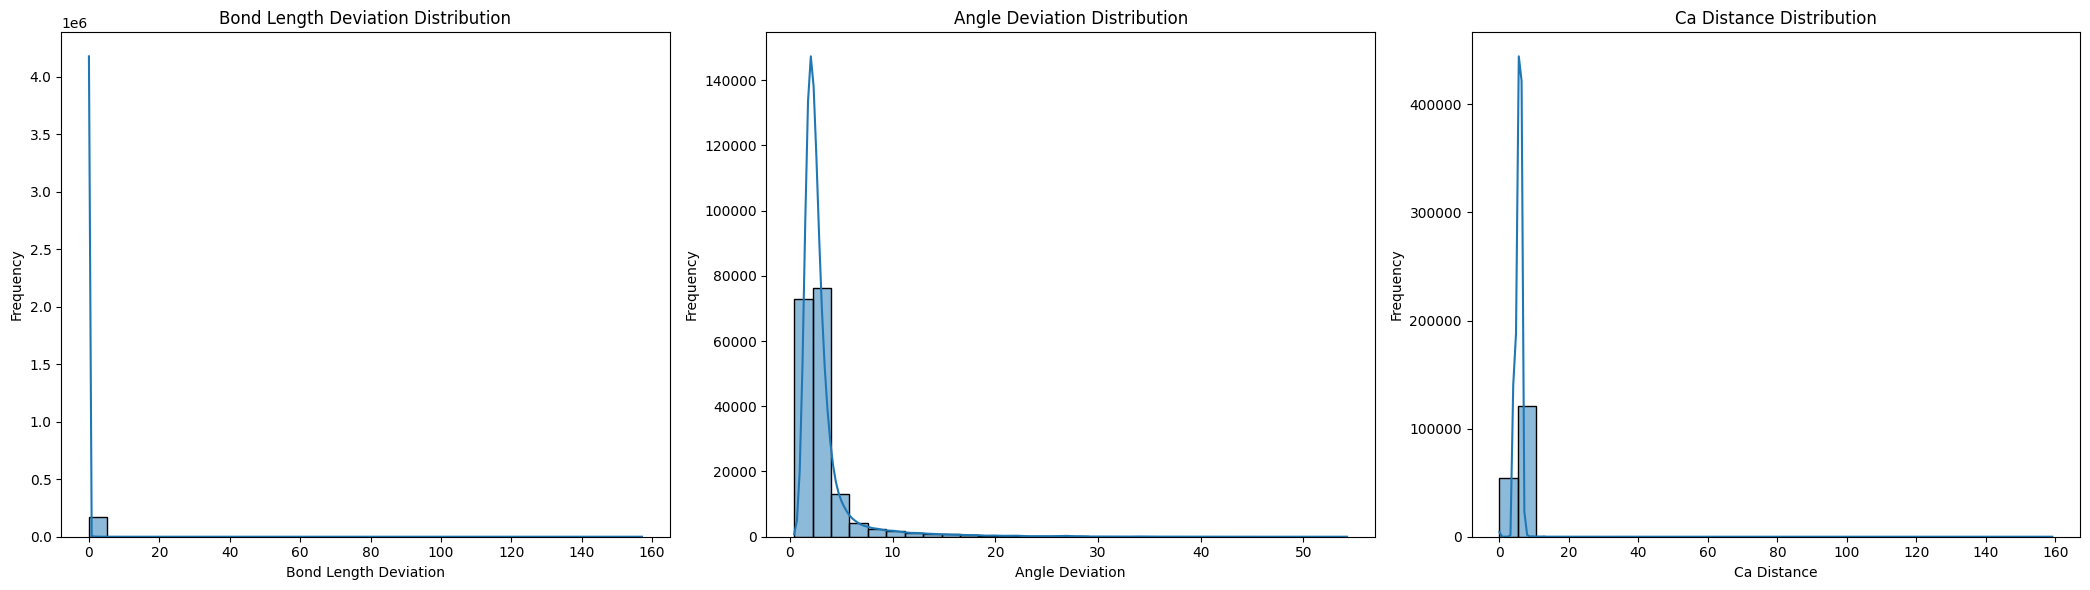

In [20]:
plot_histograms(dev_df)

In [21]:
def Ohighlight_worst_structures2(df, top_n=10):
    """
    Highlight the worst structures for distance and angle deviations and annotate their names.
    Also, add a subplot showing the worst structures aggregated by PDB_ID.

    :param df: DataFrame containing the disulfide information.
    :type df: pd.DataFrame
    :param top_n: Number of worst structures to highlight.
    :type top_n: int
    """
    # Identify the worst structures for Bond Length Deviation
    worst_distance = df.nlargest(top_n, "Distance_Deviation")

    # Identify the worst structures for angle deviation
    worst_angle = df.nlargest(top_n, "Angle_Deviation")

    # Identify the worst structures for Ca distance
    worst_ca = df.nlargest(top_n, "Ca_Distance")

    # Combine the worst structures
    worst_structures = pd.concat(
        [worst_distance, worst_angle, worst_ca]
    ).drop_duplicates()

    # Aggregate worst structures by PDB_ID
    worst_structures_agg = (
        worst_structures.groupby("PDB_ID").size().reset_index(name="Count")
    )

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Scatter plot for all structures
    sns.scatterplot(
        x="Distance_Deviation",
        y="Angle_Deviation",
        data=df,
        label="All Structures",
        ax=axes[0],
    )

    # Highlight the worst structures
    sns.scatterplot(
        x="Distance_Deviation",
        y="Angle_Deviation",
        data=worst_structures,
        color="red",
        label="Worst Structures",
        marker="X",
        s=100,
        ax=axes[0],
    )

    # Annotate the worst structures with their names
    for i, row in worst_structures.iterrows():
        axes[0].annotate(
            row["SS_Name"],
            (row["Distance_Deviation"], row["Angle_Deviation"]),
            textcoords="offset points",
            xytext=(5, 1),
            ha="left",
        )

    axes[0].set_title("Bond Length Deviation vs. Angle Deviation")
    axes[0].set_xlabel("Bond Length Deviation")
    axes[0].set_ylabel("Angle Deviation")
    axes[0].legend()

    # Bar plot for worst structures aggregated by PDB_ID
    sns.barplot(x="PDB_ID", y="Count", data=worst_structures_agg, ax=axes[1])
    axes[1].set_title("Worst Structures Aggregated by PDB_ID")
    axes[1].set_xlabel("PDB_ID")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis="x", rotation=90)

    plt.tight_layout()
    plt.show()

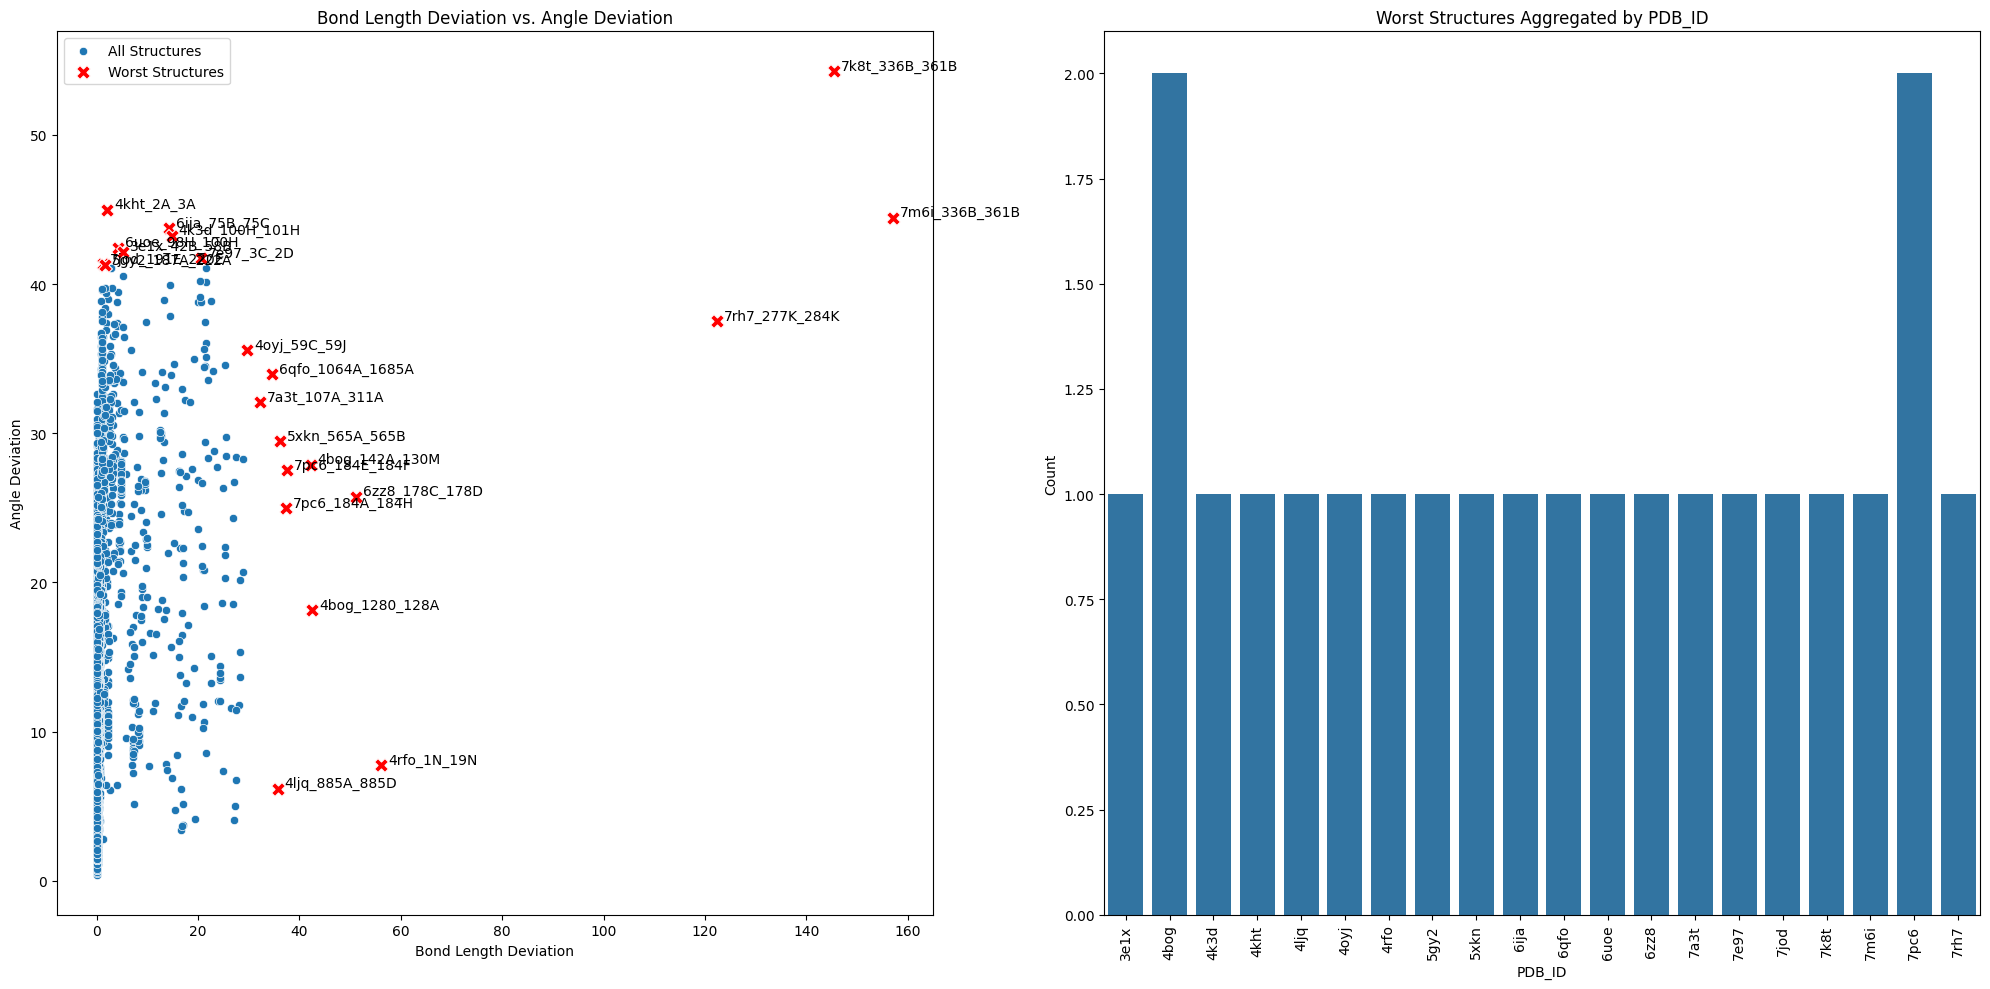

In [22]:
Ohighlight_worst_structures2(dev_df, top_n=10)

In [ ]:
highlight_worst_structures2(dev_df, top_n=10)

In [ ]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named dev_df with columns 'Distance_Deviation' and 'Angle_Deviation'

# Standard Deviation Method
distance_cutoff_std = calculate_std_cutoff(dev_df, "Distance_Deviation", num_std=3)
angle_cutoff_std = calculate_std_cutoff(dev_df, "Angle_Deviation", num_std=3)
ca_cutoff_std = calculate_std_cutoff(dev_df, "Ca_Distance", num_std=3)

# Percentile Method
distance_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Distance_Deviation", percentile=98
)
angle_cutoff_percentile = calculate_percentile_cutoff(
    dev_df, "Angle_Deviation", percentile=98
)
ca_cutoff_percentile = calculate_percentile_cutoff(dev_df, "Ca_Distance", percentile=98)

print(f"Bond Length Deviation Cutoff (3 Std Dev): {distance_cutoff_std}")
print(f"Angle Deviation Cutoff (3 Std Dev): {angle_cutoff_std}")
print(f"Ca Distance Cutoff (3 Std Dev): {ca_cutoff_std}\n")

print(f"Bond Length Deviation Cutoff (98th Percentile): {distance_cutoff_percentile}")
print(f"Angle Deviation Cutoff (98th Percentile): {angle_cutoff_percentile}")
print(f"Ca Distance Cutoff (98th Percentile): {ca_cutoff_percentile}")

In [ ]:
dev_df.shape[0]
filt = filter_by_cutoffs(dev_df, 1.0, 10.0, 8.0)
filt.shape[0]

# Publications
* https://doi.org/10.21105/joss.06169
* https://doi.org/10.5281/zenodo.13241499
* https://doi.org/10.1021/bi00368a023
* https://doi.org/10.1021/bi00368a024
* https://doi.org/10.1016/0092-8674(92)90140-8
* https://10.5281/zenodo.11148440 
